In [1]:
import nilearn
import nistats
from nistats.first_level_model import FirstLevelModel
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold

import os
import pandas
import numpy as np
import nibabel as nib
import glob

from nilearn.plotting import find_xyz_cut_coords
import matplotlib.pyplot as plt
from scipy.stats import norm

from nilearn import plotting
%matplotlib inline

/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 19

In [2]:
import h5py
import pickle as pkl
from nilearn import plotting
import matplotlib.pyplot as plt
import nibabel as nib
import re
import pandas as pd

class FirstLevels(object):
    
    def __init__(self, subject_id, session, 
                 bids_root='data/deriv/fmriprep',
                 bold_space='MNI152NLin2009cAsym',
                 models_dir_name = 'model',
                 runs = (1,2,3),
                 denoised = False,
                 me_combination_method=None, 
                 smooth_fwhm=0, 
                 echo_n=None, 
                 highpassed_data=True):
        self.subject_id = subject_id
        self.session = session
        self.bids_root = bids_root
        self.t_r = 3.
        self.bold_space = bold_space
        self.me_tes = [0.00966, 0.02487, 0.04008]
        self.me_combination_method = me_combination_method  # optcomb, PAID
        self.denoised = denoised
        self.highpassed_data = highpassed_data
        self.fwhm = smooth_fwhm
        self.echo_n = echo_n
        self.runs = runs
        
        if self.me_combination_method is not None:
            if self.me_combination_method == 'optcomb':
                self.me_extension = 'optcomb'
### Old stuff, no longer used
#             elif self.me_combination_method == 'PAID':
#                 self.me_extension = 'PAID'
#             elif self.me_combination_method == 'sm_t2star':
#                 self.me_extension = 'sm_t2star'
#             elif 'sm_te-' in self.me_combination_method:
#                 self.me_extension = self.me_combination_method
            
        self.anat_img = None

        self.session_confs_dir = os.path.join(self.bids_root, 'sub-' + self.subject_id, 'ses-' + self.session, 'func')
        if self.session == 'me' and self.denoised:
            self.session_func_dir = os.path.join(self.bids_root, '../../../lcat_denoising')
        else:
            self.session_func_dir = self.session_confs_dir
        self.anat_dir = os.path.join(self.bids_root,  'sub-' + self.subject_id, 'anat')
        
        # set-up filenames
        if self.session == 'me':
            if self.denoised:
                model_fn = 'firstlevel_fwhm-{}_lcat-den.pkl'.format(self.fwhm)
                contr_fn = 'contrasts_fwhm-{}_lcat-den.pkl'.format(self.fwhm)
            elif self.echo_n is not None:
                model_fn = 'firstlevel_fwhm-{}_echo-{}.pkl'.format(self.fwhm, self.echo_n)
                contr_fn = 'contrasts_fwhm-{}_echo-{}.pkl'.format(self.fwhm, self.echo_n)
            else:
                model_fn = 'firstlevel_fwhm-{}_comb-{}.pkl'.format(self.fwhm, self.me_extension)
                contr_fn = 'contrasts_fwhm-{}_comb-{}.pkl'.format(self.fwhm, self.me_extension)
        else:
            model_fn = 'firstlevel_fwhm-{}.pkl'.format(self.fwhm)
            contr_fn = 'contrasts_fwhm-{}.pkl'.format(self.fwhm)

        self.models_dir = os.path.join(self.session_confs_dir, '..', models_dir_name)
        self.model_file = os.path.join(self.models_dir, model_fn)
        self.contrasts_file = os.path.join(self.models_dir, contr_fn)
        
        if not os.path.exists(self.models_dir):
            os.makedirs(self.models_dir)
        
    def get_data_mask_confounds(self):
    
        if self.highpassed_data:
            hp_appendix = '-hp'
        else:
            hp_appendix = ''
            
        if self.session == 'se':
            data = [os.path.join(self.session_func_dir, 'sub-{}_ses-{}_task-stop_run-{}_space-{}_desc-preproc{}_bold.nii.gz'.format(self.subject_id, self.session, x, self.bold_space, hp_appendix)) for x in self.runs]
            mask = os.path.join(self.session_confs_dir, 'sub-{}_ses-{}_task-stop_run-1_space-{}_desc-brain_mask.nii.gz'.format(self.subject_id, self.session, self.bold_space))
            confounds = [os.path.join(self.session_confs_dir, 'sub-{}_ses-{}_task-stop_run-{}_desc-confounds_regressors.tsv'.format(self.subject_id, self.session, x)) for x in self.runs]
        else:
            mask = os.path.join(self.session_confs_dir, 'sub-{}_ses-{}_task-stop_run-1_echo-1_space-{}_desc-brain_mask.nii.gz'.format(self.subject_id, self.session, self.bold_space))
            if self.denoised:
                # denoised ME data
                data = [os.path.join(self.session_func_dir, 'sub-{}_ses-{}_task-stop_run-{}_space-{}_desc-preproc{}-{}_bold_lcat-den.nii.gz'.format(self.subject_id, self.session, x, self.bold_space, hp_appendix, self.me_extension)) for x in self.runs]
                confounds = [os.path.join(self.session_confs_dir, 'sub-{}_ses-{}_task-stop_run-{}_echo-{}_desc-confounds_regressors.tsv'.format(self.subject_id, self.session, x, 1)) for x in self.runs]
            elif self.echo_n is not None:
                # ME data, individual echo
                data = [os.path.join(self.session_func_dir, 'sub-{}_ses-{}_task-stop_run-{}_echo-{}_space-{}_desc-preproc{}_bold.nii.gz'.format(self.subject_id, self.session, x, self.echo_n, self.bold_space, hp_appendix)) for x in self.runs]
                confounds = [os.path.join(self.session_confs_dir, 'sub-{}_ses-{}_task-stop_run-{}_echo-{}_desc-confounds_regressors.tsv'.format(self.subject_id, self.session, x, self.echo_n)) for x in self.runs]
            else:
                # optimally combined (not denoised) ME data
                data = [os.path.join(self.session_func_dir, 'sub-{}_ses-{}_task-stop_run-{}_space-{}_desc-preproc{}-{}_bold.nii.gz'.format(self.subject_id, self.session, x, self.bold_space, hp_appendix, self.me_extension)) for x in self.runs]
                confounds = [os.path.join(self.session_confs_dir, 'sub-{}_ses-{}_task-stop_run-{}_echo-{}_desc-confounds_regressors.tsv'.format(self.subject_id, self.session, x, 1)) for x in self.runs]
                    
        return data, mask, confounds
    
    def get_onsets(self, run, events):
        
        fn = os.path.join(self.bids_root, 'sub-' + self.subject_id, 'ses-' + self.session, 
                          'func', 'sub-{}_ses-{}_task-stop_run-{}_events.tsv'.format(self.subject_id, self.session, run))
        df = pandas.read_csv(fn, sep='\t')
        
        # remove go/failed stop trials with RT > 1
        # 'response_time' is in time relative to run onset; 'rt' is relative to stimulus onset
        df['rt'] = df['response_time'] - df['onset']
        df = df.loc[~((df['rt'] > 1) & (df['trial_type'] != 'successful_stop'))]
        
        # only events of interest
        to_return = df[np.in1d(df.trial_type, events)].fillna(0.1)
        
        return to_return
    
    def load_confounds(self, path, fix_nans=True, 
                       include_confounds=('rot_x', 'rot_y', 'rot_z', 'trans_x', 'trans_y', 'trans_z', 'framewise_displacement'),
                       **kwargs):
        confs = pd.read_csv(path, sep='\t', **kwargs)
        
        for col in confs.columns.values:
            if pd.isnull(confs[col]).sum()>0:
                col_mean = confs[col].mean()
                confs[col] = confs[col].fillna(col_mean)
            
            # check if this column needs to be removed
            match = False
            for include in include_confounds:
                if re.match(include, col) is not None:
                    match = True
            
            if not match:
                del confs[col]
#         print(confs.columns.values)

        return confs
    
    def fit_first_level(self, events=('go_trial', 'successful_stop', 'failed_stop'),
                        smoothing_fwhm=0, n_jobs=10, overwrite=False, 
                        include_confounds=(), **kwargs):
        
        if os.path.exists(self.model_file) and not overwrite:
            print('Model already exists, loading from file...')
            with open(self.model_file, 'rb') as f:
                first_level_model = pkl.load(f)
        else:
            print('Fitting first level model...')
            data, mask, confounds = self.get_data_mask_confounds()
            
            if len(include_confounds)==0:
                confounds = None
            else:
                confounds = [self.load_confounds(x, include_confounds=include_confounds) for x in confounds]
            
            if not os.path.exists(data[0]):
                raise(IOError('Echos not yet combined, cannot run!'))
            
            paradigm = [self.get_onsets(x, events=events) for x in self.runs]
            
            first_level_model = FirstLevelModel(self.t_r, 
                                                hrf_model='glover + derivative', 
                                                smoothing_fwhm=smoothing_fwhm,
                                                mask=mask,
                                                n_jobs=n_jobs, **kwargs)
            first_level_model.fit(data, paradigm, confounds)
            self.first_level_model = first_level_model
            
            with open(self.model_file, 'wb') as f:
                pkl.dump(first_level_model, f)
        
        self.first_level_model = first_level_model
        
        return self
    
    def compute_contrasts(self, contrasts, overwrite=False):
    
        if os.path.exists(self.contrasts_file) and not overwrite:
            print('Contrast file found, loading from file...')
            with open(self.contrasts_file, 'rb') as f:
                contr_dict = pkl.load(f)
        else:
            contr_dict = {}
            for contr in contrasts:
                print('Computing contrast %s...' %contr)
                contr_dict[contr] = self.first_level_model.compute_contrast(contr)
            
            with open(self.contrasts_file, 'wb') as f:
                pkl.dump(contr_dict, f)
            
        self.contrasts = contr_dict
        
    def load_anat_img(self):
        if self.anat_img is None:
            self.anat_img = nib.load(
                os.path.join(self.anat_dir, 'sub-%s_space-%s_desc-preproc_T1w.nii.gz' %(self.subject_id, self.bold_space)))
    
    def plot_contrasts(self, contrasts=None, **kwargs):
        
        # load bg image
        self.load_anat_img()

        if contrasts is None:
            # no contrasts provided, plot all
            f, ax = plt.subplots(len(self.contrasts), 1)
            for i, (contr_name, contr) in enumerate(self.contrasts.items()):
                plotting.plot_stat_map(contr, bg_img=self.anat_img, axes=ax[i], **kwargs)
            return f, ax
        else:
            # plot one or more, specified by contrasts argument
            for contr in contrasts:
                contr_plot = plotting.plot_stat_map(self.contrasts[contr], bg_img=self.anat_img, **kwargs)
            return contr_plot

In [3]:
events = ('go_trial', 'successful_stop', 'failed_stop')

contrasts = ['failed_stop - go_trial',
             'successful_stop - go_trial',
             'failed_stop - successful_stop']

# movement parameters as only confounds
include_confounds=('framewise_displacement', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z')  

# The cell below fits all fits-level models for:
1. The optimally combined multi-echo data
2. Each echo separately
3. The single echo data
4. A denoised version of the multi-echo data

This is done both after smoothing with fwhm = 5 (standard analysis) and without smoothing (required for LISA)

So 17 subjects * 6 data sets * 2 smoothing factors --> this takes a while, even though nistats is very fast

In [4]:
n_jobs = 10
overwrite = False

for smooth in [0, 5]:
    # loop the loop
    for sub in range(1,19):
        sub_str = str(sub).zfill(2)
        
        # sub 17: final run discarded, no above-chance accuracy
        if sub == 17:
            runs = [1,2]
        else:
            runs = [1,2,3]

        for ses in ['me', 'se']:
            if ses=='me':
                if sub == 12:
                    # sub 12, ses-me failed: pp could not hear audio. SE was fine though
                    continue

                # Combined multi-echo data (loop because at some point I also tried PAID, 
                # but not really different from OC)
                for me_comb in ['optcomb']:
                    print('Subject {}, session {}, {}... '.format(sub_str, ses, me_comb), end='')

                    model = FirstLevels(sub_str, ses, 
                                        bids_root='./data/deriv/fmriprep/', 
                                        bold_space='MNI152NLin2009cAsym',
                                        me_combination_method=me_comb,
                                        models_dir_name='model_final',
                                        runs=runs,
                                        smooth_fwhm=smooth,
                                        denoised=False,
                                        highpassed_data=True)
                    model.fit_first_level(n_jobs=n_jobs, 
                                          include_confounds=include_confounds, 
                                          smoothing_fwhm=smooth, 
                                          drift_model=None, overwrite=overwrite, slice_time_ref=0.5)
#                     model.compute_contrasts(contrasts, overwrite=overwrite)

                # Denoised multi-echo data. Not included in manuscript. Didn't really work.
                print('Subject {}, session {}, denoised... '.format(sub_str, ses), end='')
                model = FirstLevels(sub_str, session='me', 
                                    bids_root='./data/deriv/fmriprep/', 
                                    bold_space='MNI152NLin2009cAsym',
                                    me_combination_method=me_comb,
                                    models_dir_name='model_oc_denoised_final',
                                    smooth_fwhm=smooth,
                                    runs=runs,
                                    denoised=True,
                                    highpassed_data=True)
                model.fit_first_level(n_jobs=n_jobs, 
                                      include_confounds=include_confounds, 
                                      smoothing_fwhm=smooth, 
                                      drift_model=None, 
                                      overwrite=overwrite, 
                                      slice_time_ref=0.5)
    #             model.compute_contrasts(contrasts, overwrite=overwrite)

                # Multi-echo data, per echo separately
                for echo_n in [1,2,3]:
                    print('Subject {}, session {}, echo {}... '.format(sub_str, ses, echo_n), end='')
                    model = FirstLevels(sub_str, ses, 
                                        bids_root='./data/deriv/fmriprep/', 
                                        bold_space='MNI152NLin2009cAsym',
                                        me_combination_method=None,
                                        models_dir_name='model_echo_{}_final'.format(echo_n),
                                        runs=runs,
                                        smooth_fwhm=smooth,
                                        echo_n=echo_n,
                                        highpassed_data=True)
                    model.fit_first_level(n_jobs=n_jobs, 
                                          include_confounds=include_confounds, 
                                          smoothing_fwhm=smooth, 
                                          drift_model=None, 
                                          overwrite=overwrite, 
                                          slice_time_ref=0.5)
#                     model.compute_contrasts(contrasts, overwrite=overwrite)
            else:
                # Single-echo data
                print('Subject {}, session {}... '.format(sub_str, ses), end='')
                model = FirstLevels(sub_str, ses, 
                            bids_root='./data/deriv/fmriprep/', 
                            bold_space='MNI152NLin2009cAsym',
                            models_dir_name='model_final',
                            smooth_fwhm=smooth,
                            runs=runs, highpassed_data=True)
                model.fit_first_level(n_jobs=n_jobs, 
                                      include_confounds=include_confounds, 
                                      smoothing_fwhm=smooth,
                                      drift_model=None, 
                                      overwrite=overwrite, 
                                      slice_time_ref=0.5)
#                 model.compute_contrasts(contrasts, overwrite=overwrite)

Subject 01, session me, optcomb... Model already exists, loading from file...
Subject 01, session me, denoised... Model already exists, loading from file...
Subject 01, session me, echo 1... Model already exists, loading from file...
Subject 01, session me, echo 2... Model already exists, loading from file...
Subject 01, session me, echo 3... Model already exists, loading from file...
Subject 01, session se... Model already exists, loading from file...
Subject 02, session me, optcomb... Model already exists, loading from file...
Subject 02, session me, denoised... Model already exists, loading from file...
Subject 02, session me, echo 1... Model already exists, loading from file...
Subject 02, session me, echo 2... Model already exists, loading from file...
Subject 02, session me, echo 3... Model already exists, loading from file...
Subject 02, session se... Model already exists, loading from file...
Subject 03, session me, optcomb... Model already exists, loading from file...
Subject 

Subject 01, session se... Model already exists, loading from file...
Subject 02, session me, optcomb... Model already exists, loading from file...
Subject 02, session me, denoised... Model already exists, loading from file...
Subject 02, session me, echo 1... Model already exists, loading from file...
Subject 02, session me, echo 2... Model already exists, loading from file...
Subject 02, session me, echo 3... Model already exists, loading from file...
Subject 02, session se... Model already exists, loading from file...
Subject 03, session me, optcomb... Model already exists, loading from file...
Subject 03, session me, denoised... Model already exists, loading from file...
Subject 03, session me, echo 1... Model already exists, loading from file...
Subject 03, session me, echo 2... Model already exists, loading from file...
Subject 03, session me, echo 3... Model already exists, loading from file...
Subject 03, session se... Model already exists, loading from file...
Subject 04, sessi

### Second level models

In [5]:
ses = 'se'
me_comb = 'optcomb'  # or PAID
first_level_models_se = []
first_level_models_me = []
smooth = 5

for sub in np.arange(1, 19):
    sub_str = str(sub).zfill(2)
    print(sub_str)
    if sub == 12:
        continue
    
    # load se
    model = FirstLevels(sub_str, 'se', 
                        bids_root='./data/deriv/fmriprep/', 
                        bold_space='MNI152NLin2009cAsym',
                        me_combination_method=None,
                        models_dir_name='model_final',
                        highpassed_data=True,
                        smooth_fwhm=smooth)
    model.fit_first_level(n_jobs=6, include_confounds=include_confounds)
    first_level_models_se.append(model.first_level_model)
    
    # load me
    model = FirstLevels(sub_str, 'me', 
                        bids_root='./data/deriv/fmriprep/', 
                        bold_space='MNI152NLin2009cAsym',
                        me_combination_method=me_comb,
                        models_dir_name='model_final',
                        highpassed_data=True,
                        smooth_fwhm=smooth)
    model.fit_first_level(n_jobs=6, include_confounds=include_confounds)
    first_level_models_me.append(model.first_level_model)

01
Model already exists, loading from file...
Model already exists, loading from file...
02
Model already exists, loading from file...
Model already exists, loading from file...
03
Model already exists, loading from file...
Model already exists, loading from file...
04
Model already exists, loading from file...
Model already exists, loading from file...
05
Model already exists, loading from file...
Model already exists, loading from file...
06
Model already exists, loading from file...
Model already exists, loading from file...
07
Model already exists, loading from file...
Model already exists, loading from file...
08
Model already exists, loading from file...
Model already exists, loading from file...
09
Model already exists, loading from file...
Model already exists, loading from file...
10
Model already exists, loading from file...
Model already exists, loading from file...
11
Model already exists, loading from file...
Model already exists, loading from file...
12
13
Model already e

### Smooth 5mm (deH et al)

In [6]:
class SLM(object):
    """ Second Level Model; can either use standard smoothing + theoretical FDR or LISA """
    
    def __init__(self, first_level_models, 
                 contrasts, session=None,
                 bids_root='./data/deriv/fmriprep',
                 model_dir='',
                 smoothing_fwhm=None, height_control='fdr', level=0.05,
                 save_dir='./second_level_models'):
        
        self.first_level_models = first_level_models
        self.session = session
        self.model_dir = model_dir
        self.bids_root = bids_root
        self.contrasts = contrasts
        self.smoothing_fwhm = smoothing_fwhm
        self.height_control = height_control
        self.level = level
        self.thresholds = []
        self.zmaps = {}
        self.save_dir = save_dir
        
        self.lisa_tmp_dir = '/home/stevenm/lisa_tmp_dir'
        
    def fit(self):
        
        if self.height_control == 'fdr':
            self._fit_classical()
            return self
        
        elif self.height_control == 'LISA':
            self._fit_lisa()
            return self
        
    def _get_first_level_cmaps(self, contrast_name):
        
        contrast_fn = 'sub-*_contrast-{}_estimate.nii.gz'.format(contrast_name.replace(' ', ''))
        path = os.path.join(self.bids_root, 
                            'sub-*', 
                            'ses-{}'.format(self.session), 
                            self.model_dir, 
                            'contrast_estimates', 
                            contrast_fn)
#         print(contrast_fn)
#         print(path)
        first_level_cmaps = glob.glob(path)
        return first_level_cmaps
        
    def _load_if_exists(self, fn):
        path = os.path.join(self.save_dir, fn)
        if os.path.exists(path):
            return nib.load(path)
        else:
            return None
        
    def _save_contrast_nii(self, nii, fn):
        # save second level models
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        
        nib.save(nii, os.path.join(self.save_dir, fn))
        
    def _fit_lisa(self):
        # empty contrasts dictionary, will point to filenames
#         self.first_level_contrasts = {x: [] for x in self.contrasts.keys()}
        
        if not os.path.exists(self.lisa_tmp_dir):
            os.makedirs(self.lisa_tmp_dir)
    
        for contrast_name, contrast in self.contrasts.items():
            
            # try to load previously run first...
            contrast_fn = 'second_level_contrast-{}.nii.gz'.format(contrast_name)
            contrast_nii = self._load_if_exists(contrast_fn)
            if contrast_nii is not None:
                self.zmaps[contrast_name] = contrast_nii
                continue
            
            first_level_fns = []
            
            for i, first_level_model in enumerate(self.first_level_models):
                contrast_map = first_level_model.compute_contrast(contrast, output_type='effect_size')
                fn = 'sub-{}_contrast-{}_effectsize.nii.gz'.format(i, contrast_name)
                first_level_fns.append(fn)
                nib.save(contrast_map, os.path.join(self.lisa_tmp_dir, fn))

            print(first_level_fns)
            print('Converting to float32 using fslmaths...')
            fns_full = [os.path.join(self.lisa_tmp_dir, x) for x in first_level_fns]
            for fn in fns_full:
                os.system('fslmaths {} {} -odt float'.format(fn, fn)) 

            cmd_onesample = self._make_lipsia_command(fns=first_level_fns)
            cmd_conversion = self._make_lipsia_vnifti_command()
            print('Running command: {}'.format(cmd_onesample))
            lipsia_output_onesample = os.system(cmd_onesample)
            print('done, output: {}'.format(lipsia_output_onesample))
            
            print('Running command: {}'.format(cmd_conversion))
            lipsia_output_conversion = os.system(cmd_conversion)
            print('done, output: {}'.format(lipsia_output_conversion))
            
            # cleanup
            print('cleanup...')
            [os.remove(os.path.join(self.lisa_tmp_dir, x)) for x in first_level_fns]
            os.remove(os.path.join(self.lisa_tmp_dir, 'second_level_contrast.v'))
            
            self.zmaps[contrast_name] = nib.load(os.path.join(self.lisa_tmp_dir, 'second_level_contrast.nii'))
            self._save_contrast_nii(self.zmaps[contrast_name], contrast_fn)
            
    def _make_lipsia_command(self, fns, out_fn='/data/second_level_contrast.v', docker=True):

        if docker:
            fns = ['/data/' + x for x in fns]  # make sure to point at the /data-directory inside the Docker container
            cmd = ['docker', 'run', '-v', self.lisa_tmp_dir + ':/data', 
                   'lipsia', 'vlisa_onesample', '-alpha', str(self.level), '-in']
            cmd += fns
            cmd += ['-out', out_fn, '-cleanup', 'false']
            cmd = ' '.join(cmd)
        else:
            # not implemented
            pass
        
        return cmd
    
    def _make_lipsia_vnifti_command(self, fn='/data/second_level_contrast', docker=True):
        
        if docker:
            cmd = ['docker', 'run', '-v', self.lisa_tmp_dir + ':/data', 
                   'lipsia', 'vnifti', '-in', fn + '.v', '-out', fn + '.nii']
            cmd = ' '.join(cmd)
        else:
            # not implemented
            pass
        
        return cmd
            
    def _fit_classical(self):
        
        self.second_level_model = SecondLevelModel(smoothing_fwhm=self.smoothing_fwhm)
        self.second_level_model.fit(self.first_level_models)

        self._make_zmaps()
        self._get_thresholds()
        
        return self
        
    def _make_zmaps(self):
        for contrast_name, contrast in self.contrasts.items():
            self.zmaps[contrast_name] = self.second_level_model.compute_contrast(first_level_contrast=contrast)
        
    def _get_thresholds(self):
        for contrast_name, contrast in self.contrasts.items():
            self.thresholds.append(map_threshold(self.zmaps[contrast_name], level=self.level, height_control=self.height_control)[1])

def order_maps_thresholds(zmaps_list, thresholds_list=None):
    """ Orders zmaps & thresholds for plotting """
    
    keys = [x for x in zmaps_list[0].keys()]
    zmaps_combined = [l[keys[i]] for i in range(len(keys)) for l in zmaps_list]
    
    if thresholds_list is not None:
        thresholds_combined = [t[i] for i in range(len(thresholds_list[0])) for t in thresholds_list]
        return zmaps_combined, thresholds_combined
    else:
        return zmaps_combined

## Plot 1: Main contrasts of interest, classical correction

In [7]:
from utils import *

In [8]:
contrasts = {'failed_stop - go_trial': 'failed_stop - go_trial',
             'successful_stop - go_trial': 'successful_stop - go_trial',
             'failed_stop - successful_stop': 'failed_stop - successful_stop'}

slm_se = SLM(first_level_models=first_level_models_se, contrasts=contrasts, session='se', model_dir='model', 
             smoothing_fwhm=0, height_control='fdr').fit()
slm_me = SLM(first_level_models=first_level_models_me, contrasts=contrasts, session='me', model_dir='model', 
             smoothing_fwhm=0, height_control='fdr').fit()

zmaps_combined, thresholds_combined = order_maps_thresholds([slm_se.zmaps, slm_me.zmaps], 
                                                            [slm_se.thresholds, slm_me.thresholds])

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarn

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


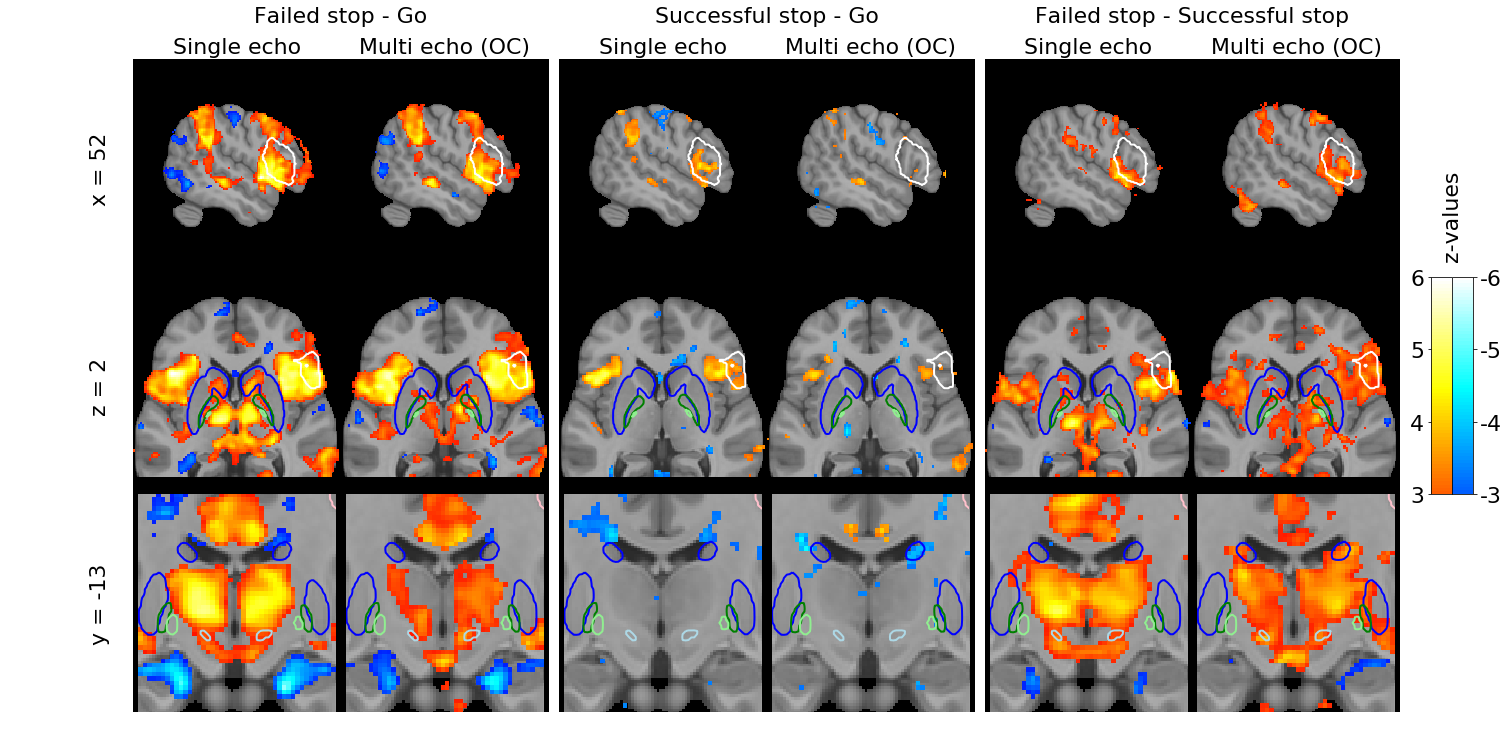

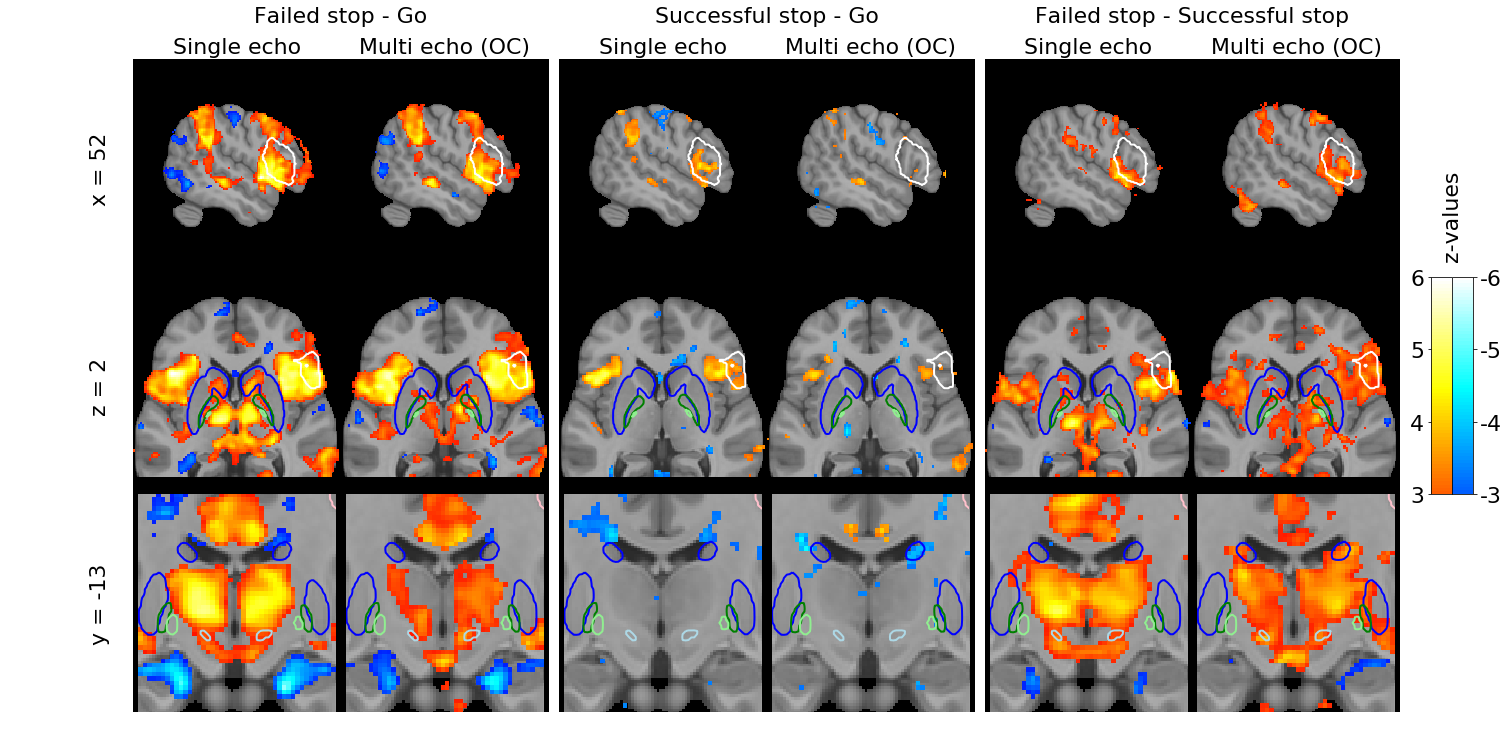

In [9]:
import matplotlib
fontsize = 22
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

f, axes = plot_3x6(zmaps_combined, 
                   thresholds_combined, 
                   contrast_names=('Failed stop - Go', 
                                   'Successful stop - Go',
                                   'Failed stop - Successful stop'),
                   titles=('Single echo', 'Multi echo (OC)', 
                           'Single echo', 'Multi echo (OC)', 
                           'Single echo', 'Multi echo (OC)')
                   )
axes[0,0].set_ylabel('x = 51', labelpad=0)
axes[1,0].set_ylabel('y = 2', labelpad=0)
axes[2,0].set_ylabel('z = -13', labelpad=0)
f

In [10]:
f.savefig('figures/glms_classical.pdf', bbox_inches='tight')

In [11]:
import pickle
with open('glm_figure_axes/zmaps.pkl', 'wb') as fid:
    pickle.dump(zmaps_combined, fid)
    
with open('glm_figure_axes/thresholds.pkl', 'wb') as fid:
    pickle.dump(thresholds_combined, fid)

## Plot 2: Events against baseline, classical correction


In [12]:
contrasts = {'failed_stop': 'failed_stop',
             'successful_stop': 'successful_stop',
             'go_trial': 'go_trial'}

slm_me = SLM(first_level_models_me, contrasts, smoothing_fwhm=5, height_control='fdr').fit()
slm_se = SLM(first_level_models_se, contrasts, smoothing_fwhm=5, height_control='fdr').fit()

zmaps_combined, thresholds_combined = order_maps_thresholds([slm_se.zmaps, slm_me.zmaps], 
                                                            [slm_se.thresholds, slm_me.thresholds])

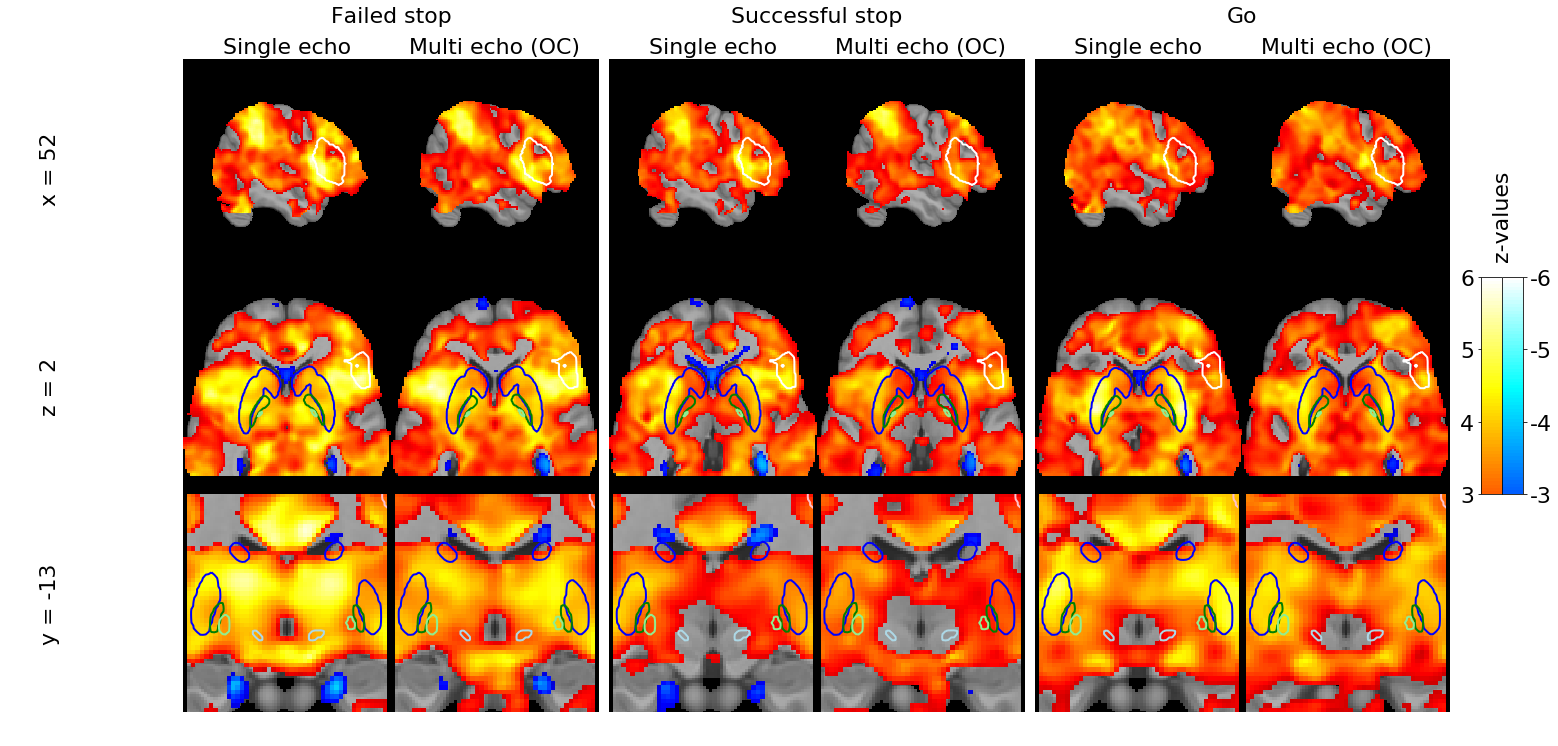

In [13]:
_ = plot_3x6(zmaps_combined, thresholds_combined, contrast_names=('Failed stop', 
                                                                  'Successful stop',
                                                                  'Go'))

## Plot 3: Events against baseline, derivatives, classical correction

In [14]:
contrasts = {'failed_stop_derivative': 'failed_stop_derivative',
             'successful_stop_derivative': 'successful_stop_derivative',
             'go_trial_derivative': 'go_trial_derivative'}

slm_me = SLM(first_level_models_me, contrasts, smoothing_fwhm=5, height_control='fdr').fit()
slm_se = SLM(first_level_models_se, contrasts, smoothing_fwhm=5, height_control='fdr').fit()

zmaps_combined, thresholds_combined = order_maps_thresholds([slm_se.zmaps, slm_me.zmaps], 
                                                            [slm_se.thresholds, slm_me.thresholds])

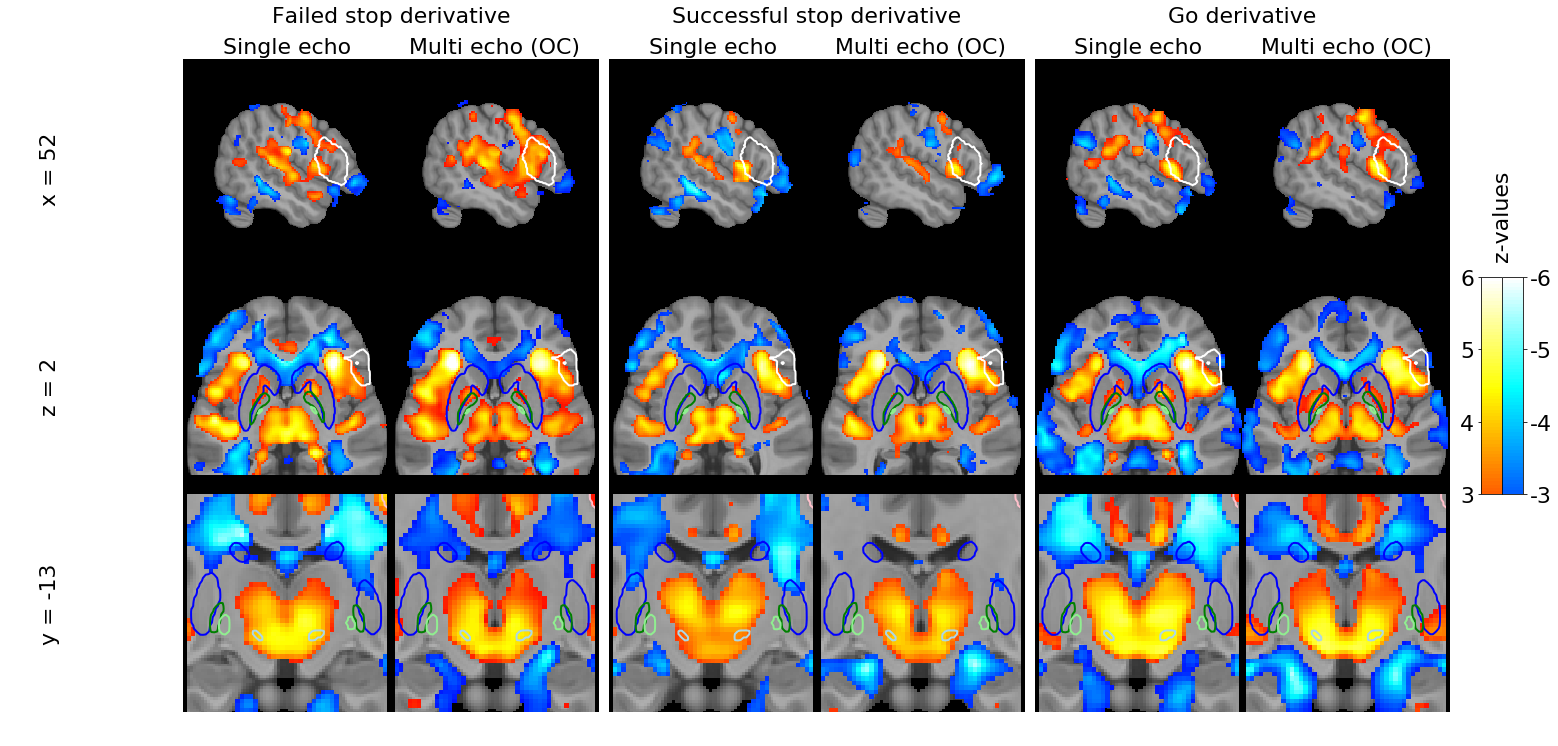

In [15]:
_ = plot_3x6(zmaps_combined, thresholds_combined, contrast_names=('Failed stop derivative', 
                                                                  'Successful stop derivative',
                                                                  'Go derivative'))

## Plot 4: Derivatives contrasts, classical correction

In [16]:
contrasts = {'failed_stop_derivative - go_trial_derivative': 'go_trial_derivative',
             'successful_stop_derivative - go_trial_derivative': 'successful_stop_derivative - go_trial_derivative',
             'failed_stop_derivative - successful_stop_derivative': 'failed_stop_derivative - successful_stop_derivative'}

slm_me = SLM(first_level_models_me, contrasts, smoothing_fwhm=5, height_control='fdr').fit()
slm_se = SLM(first_level_models_se, contrasts, smoothing_fwhm=5, height_control='fdr').fit()

zmaps_combined, thresholds_combined = order_maps_thresholds([slm_se.zmaps, slm_me.zmaps], 
                                                            [slm_se.thresholds, slm_me.thresholds])

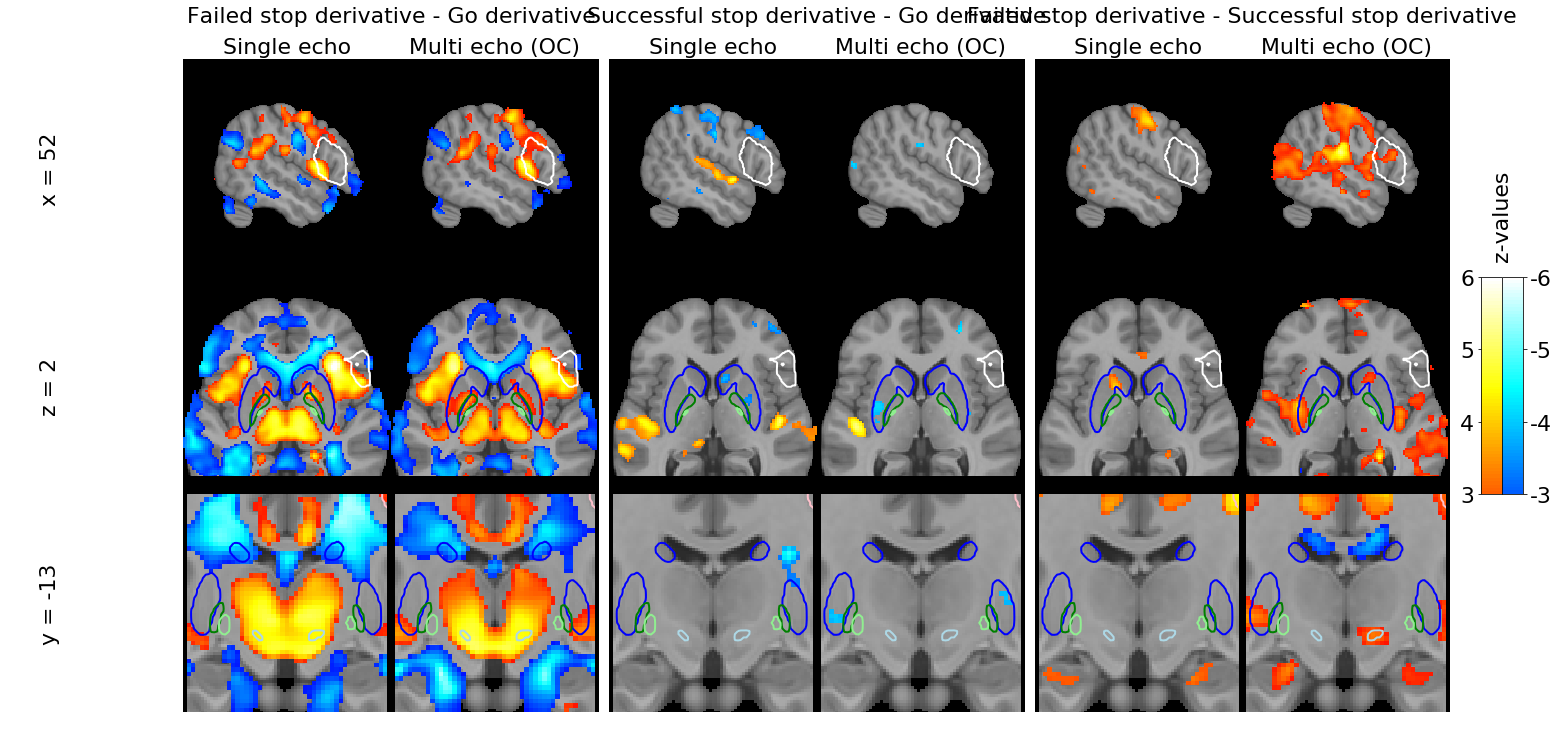

In [17]:
_ = plot_3x6(zmaps_combined, thresholds_combined, contrast_names=('Failed stop derivative - Go derivative', 
                                                                  'Successful stop derivative - Go derivative',
                                                                  'Failed stop derivative - Successful stop derivative'))

# Denoised data
Multi-echo data was denoised using local contrast & time denoising (LCaT-me), developed by Pilou. Unfortunately the results don't indicate a large difference..

In [18]:
# load data
first_level_models_meden = []
for sub in np.arange(1, 19):
    sub_str = str(sub).zfill(2)
    print(sub_str)
    if sub == 12:
        continue
    model = FirstLevels(sub_str, 'me', 
                        bids_root='./data/deriv/fmriprep/', 
                        bold_space='MNI152NLin2009cAsym',
                        me_combination_method='optcomb',
                        models_dir_name='model_oc_denoised_final',
                        highpassed_data=True, denoised=True,
                        smooth_fwhm=5)
    model.fit_first_level(n_jobs=-17, overwrite=False, 
                          include_confounds=include_confounds, slice_time_ref=0.5, drift_model=None)
    first_level_models_meden.append(model.first_level_model)

01
Model already exists, loading from file...
02
Model already exists, loading from file...
03
Model already exists, loading from file...
04
Model already exists, loading from file...
05
Model already exists, loading from file...
06
Model already exists, loading from file...
07
Model already exists, loading from file...
08
Model already exists, loading from file...
09
Model already exists, loading from file...
10
Model already exists, loading from file...
11
Model already exists, loading from file...
12
13
Model already exists, loading from file...
14
Model already exists, loading from file...
15
Model already exists, loading from file...
16
Model already exists, loading from file...
17
Model already exists, loading from file...
18
Model already exists, loading from file...


In [19]:
contrasts = {'failed_stop': 'failed_stop',
             'successful_stop': 'successful_stop',
             'go_trial': 'go_trial'}

slm_me = SLM(first_level_models_me, contrasts, smoothing_fwhm=0, height_control='fdr').fit()
slm_meden = SLM(first_level_models_meden, contrasts, smoothing_fwhm=0, height_control='fdr').fit()

zmaps_combined, thresholds_combined = order_maps_thresholds([slm_me.zmaps, slm_meden.zmaps], 
                                                            [slm_me.thresholds, slm_meden.thresholds])

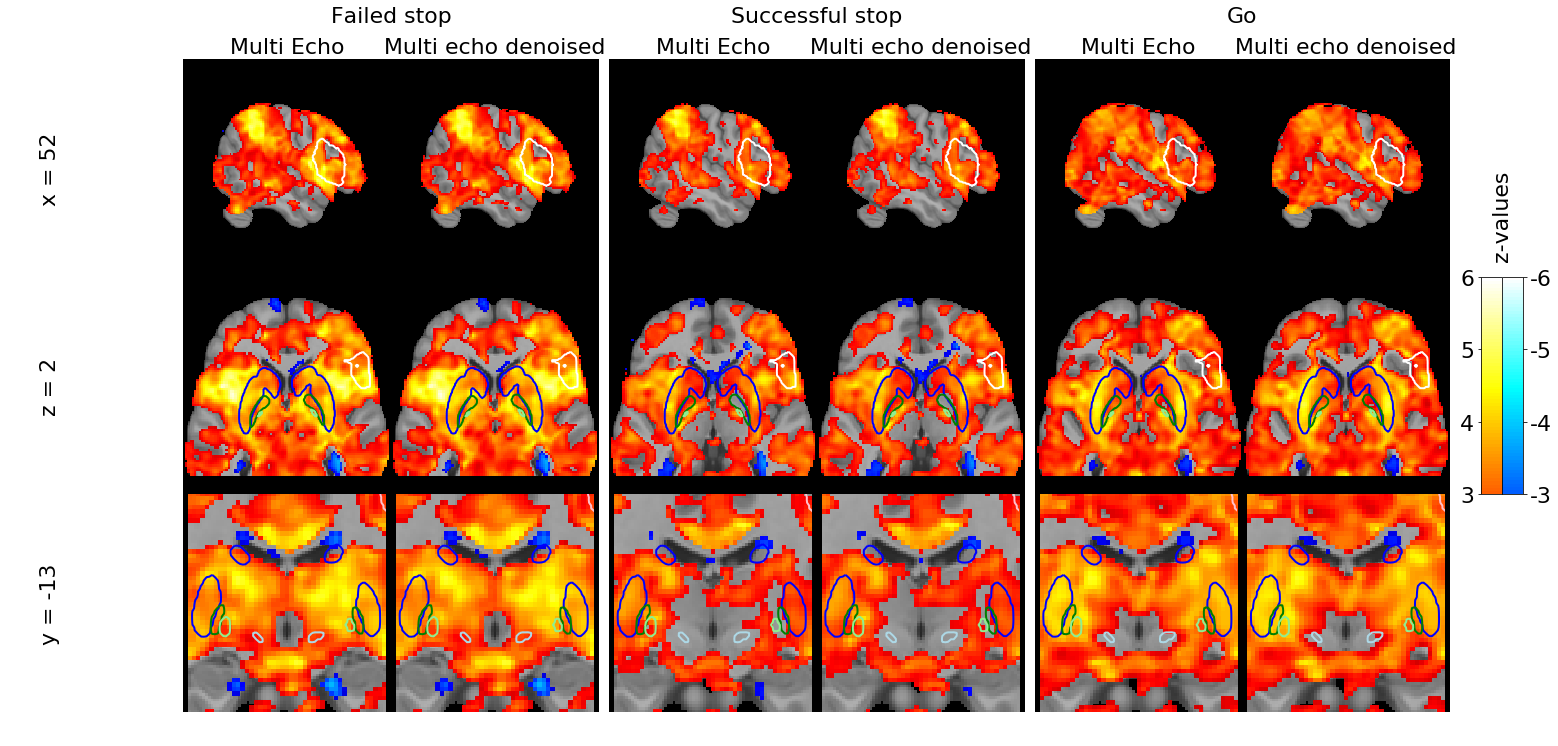

In [20]:
_ = plot_3x6(zmaps_combined, thresholds_combined, contrast_names=('Failed stop', 
                                                                  'Successful stop',
                                                                  'Go'),
             titles=('Multi Echo', 'Multi echo denoised', 'Multi Echo', 'Multi echo denoised', 'Multi Echo', 'Multi echo denoised'))

In [21]:
contrasts = {'failed_stop - go_trial': 'failed_stop - go_trial',
             'successful_stop - go_trial': 'successful_stop - go_trial',
             'failed_stop - successful_stop': 'failed_stop - successful_stop'}

slm_se = SLM(first_level_models=first_level_models_se, contrasts=contrasts, session='se', model_dir='model', 
             smoothing_fwhm=0, height_control='fdr').fit()
slm_meden = SLM(first_level_models_meden, contrasts, smoothing_fwhm=0, height_control='fdr').fit()

zmaps_combined, thresholds_combined = order_maps_thresholds([slm_se.zmaps, slm_meden.zmaps], 
                                                            [slm_se.thresholds, slm_meden.thresholds])

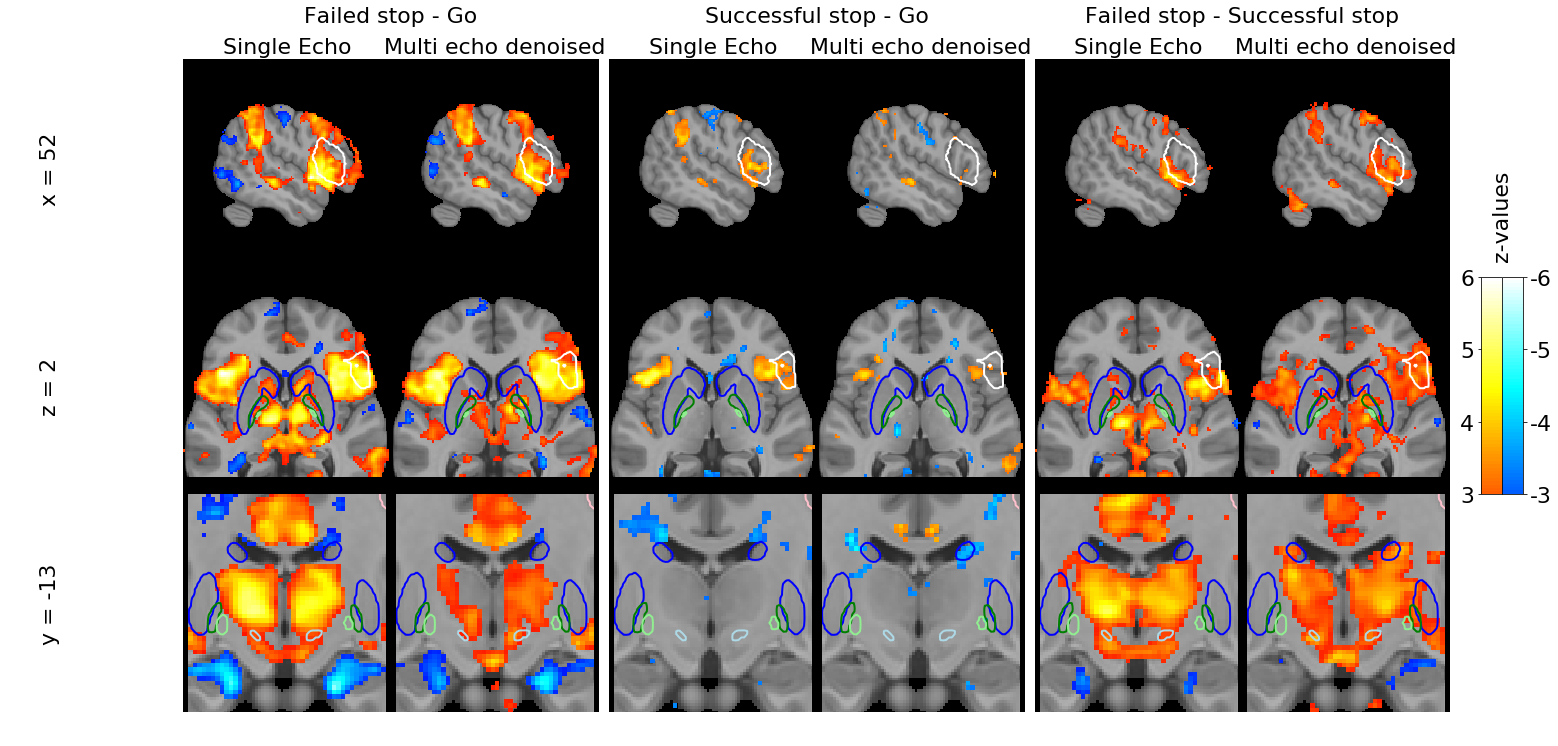

In [22]:
_ = plot_3x6(zmaps_combined, thresholds_combined, contrast_names=('Failed stop - Go', 
                             'Successful stop - Go',
                             'Failed stop - Successful stop'),
             titles=('Single Echo', 'Multi echo denoised', 
                     'Single Echo', 'Multi echo denoised', 
                     'Single Echo', 'Multi echo denoised'))

## GLM by echo

Compare the results across echos

In [23]:
first_level_models_echo_1 = []
first_level_models_echo_2 = []
first_level_models_echo_3 = []

for sub in np.arange(1, 19):
    sub_str = str(sub).zfill(2)
    print(sub_str)
    if sub == 12:
        continue
    
    for echo_n, list_ in zip(np.arange(1,4), [first_level_models_echo_1,
                                              first_level_models_echo_2,
                                              first_level_models_echo_3]):
        # load me
        model = FirstLevels(sub_str, 'me', 
                            bids_root='./data/deriv/fmriprep/', 
                            bold_space='MNI152NLin2009cAsym',
                            models_dir_name='model_echo_{}_final'.format(echo_n),
                            me_combination_method=None,
                            echo_n=echo_n, smooth_fwhm=5,
                            highpassed_data=True)
        model.fit_first_level(n_jobs=-10, 
                              drift_model=None,
                              smoothing_fwhm=5, 
                              include_confounds=include_confounds, overwrite=False, 
                              slice_time_ref=0.5)
        model.compute_contrasts(contrasts)
        list_.append(model.first_level_model)

01
Model already exists, loading from file...
Contrast file found, loading from file...
Model already exists, loading from file...
Contrast file found, loading from file...
Model already exists, loading from file...
Contrast file found, loading from file...
02
Model already exists, loading from file...
Contrast file found, loading from file...
Model already exists, loading from file...
Contrast file found, loading from file...
Model already exists, loading from file...
Contrast file found, loading from file...
03
Model already exists, loading from file...
Contrast file found, loading from file...
Model already exists, loading from file...
Contrast file found, loading from file...
Model already exists, loading from file...
Contrast file found, loading from file...
04
Model already exists, loading from file...
Contrast file found, loading from file...
Model already exists, loading from file...
Contrast file found, loading from file...
Model already exists, loading from file...
Contrast f

In [24]:
contrasts = {'failed_stop - go_trial': 'failed_stop - go_trial',
             'successful_stop - go_trial': 'successful_stop - go_trial',
             'failed_stop - successful_stop': 'failed_stop - successful_stop'}

slm_e1 = SLM(first_level_models_echo_1, contrasts=contrasts, smoothing_fwhm=0, height_control='fdr').fit()
slm_e2 = SLM(first_level_models_echo_2, contrasts=contrasts, smoothing_fwhm=0, height_control='fdr').fit()
slm_e3 = SLM(first_level_models_echo_3, contrasts=contrasts, smoothing_fwhm=0, height_control='fdr').fit()

zmaps_combined, thresholds_combined = order_maps_thresholds([slm_e1.zmaps, slm_e2.zmaps, slm_e3.zmaps], 
                                                            [slm_e1.thresholds, slm_e2.thresholds, slm_e3.thresholds])

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/utils.py:286: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)


Text(0.5, 1.0, 'z-values')

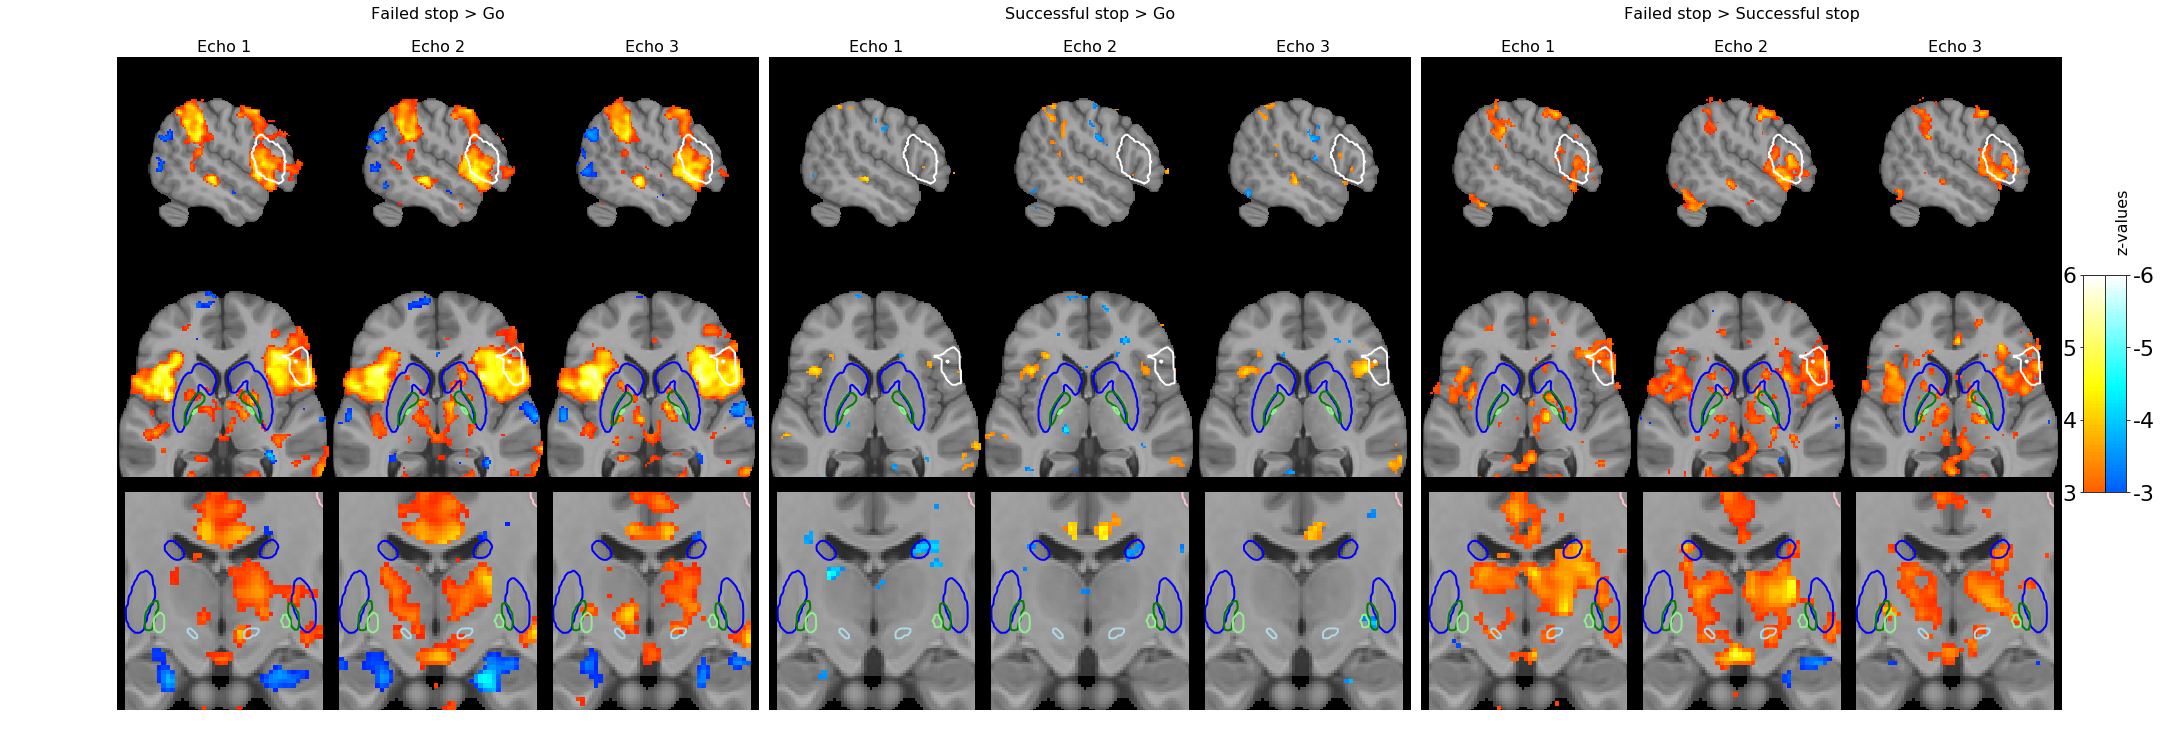

In [25]:
from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1, 1, 1, 0.05, 1, 1, 1, .05, 1, 1, 1, .1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps_combined)+5, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps_combined)+5, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps_combined, roi_dict=get_roi_dict(), z_threshold=thresholds_combined,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[52], None, [-13]],
                          bg_img='/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii',
                          vmax=6, #colorbar=False, 
                          plot_columns=(0,1,2,4,5,6,8,9,10),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('Echo 1', size=16)
axes[0,1].set_title('Echo 2', size=16)
axes[0,2].set_title('Echo 3', size=16)
axes[0,4].set_title('Echo 1', size=16)
axes[0,5].set_title('Echo 2', size=16)
axes[0,6].set_title('Echo 3', size=16)
axes[0,8].set_title('Echo 1', size=16)
axes[0,9].set_title('Echo 2', size=16)
axes[0,10].set_title('Echo 3', size=16)

for row in range(axes.shape[0]):
    axes[row,3].set_visible(False)
    axes[row,7].set_visible(False)
    axes[row,11].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)
    
# for titles: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
ext = []
#loop over the columns (j) and rows(i) to populate subplots
for j in range(11):
    # save the axes bounding boxes for later use
    ext.append([axes[0,j].get_window_extent().x0, axes[0,j].get_window_extent().width ])

# make nice
inv = f.transFigure.inverted()
width_left = ext[0][0]+(ext[2][0]+ext[2][1]-ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )

width_mid = ext[4][0]+(ext[6][0]+ext[6][1]-ext[4][0])/2.
mid_center = inv.transform( (width_mid, 1) )

width_right = ext[8][0]+(ext[10][0]+ext[10][1]-ext[8][0])/2.
right_center = inv.transform( (width_right, 1) )

# set column spanning title 
# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(left_center[0], .93, "Failed stop > Go", va="center", ha="center", size=16)
plt.figtext(mid_center[0], .93, "Successful stop > Go", va="center", ha="center", size=16)
plt.figtext(right_center[0], .93, "Failed stop > Successful stop", va="center", ha="center", size=16)

# colorbar
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax2 = f.add_subplot(gs[1,-1])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, truncation_limits=(3,6), offset=thresholds_combined[0], flip=False)
cbar_ax2 = draw_custom_colorbar(colorbar_ax=cbar_ax2, truncation_limits=(-3,-6), offset=thresholds_combined[0], flip=True)
cbar_ax2.set_title('z-values', rotation=90, fontsize=16, ha='left', pad=75)

# f.savefig('./glm.pdf')#, bbox_inches='tight')

# LISA
## Plot 1: Contrasts

In [26]:
ses = 'se'
me_comb = 'optcomb'  # or PAID
first_level_models_se = []
first_level_models_me = []
smooth = 0  # No smoothing here!

for sub in np.arange(1, 19):
    sub_str = str(sub).zfill(2)
    print(sub_str)
    if sub == 12:
        continue
    
    # load se
    model = FirstLevels(sub_str, 'se', 
                        bids_root='./data/deriv/fmriprep/', 
                        bold_space='MNI152NLin2009cAsym',
                        me_combination_method=None,
                        models_dir_name='model_final',
                        highpassed_data=True,
                        smooth_fwhm=smooth)
    model.fit_first_level(n_jobs=6, include_confounds=include_confounds)
    first_level_models_se.append(model.first_level_model)
    
    # load me
    model = FirstLevels(sub_str, 'me', 
                        bids_root='./data/deriv/fmriprep/', 
                        bold_space='MNI152NLin2009cAsym',
                        me_combination_method=me_comb,
                        models_dir_name='model_final',
                        highpassed_data=True,
                        smooth_fwhm=smooth)
    model.fit_first_level(n_jobs=6, include_confounds=include_confounds)
    first_level_models_me.append(model.first_level_model)

01
Model already exists, loading from file...
Model already exists, loading from file...
02
Model already exists, loading from file...
Model already exists, loading from file...
03
Model already exists, loading from file...
Model already exists, loading from file...
04
Model already exists, loading from file...
Model already exists, loading from file...
05
Model already exists, loading from file...
Model already exists, loading from file...
06
Model already exists, loading from file...
Model already exists, loading from file...
07
Model already exists, loading from file...
Model already exists, loading from file...
08
Model already exists, loading from file...
Model already exists, loading from file...
09
Model already exists, loading from file...
Model already exists, loading from file...
10
Model already exists, loading from file...
Model already exists, loading from file...
11
Model already exists, loading from file...
Model already exists, loading from file...
12
13
Model already e

In [27]:
def log10_transformed(hdr):
    dat = hdr.get_data().copy()
    return nib.Nifti1Image(-np.log10(1-dat), hdr.affine)

In [28]:
contrasts = {'failed_stop-go_trial': 'failed_stop - go_trial',
             'successful_stop-go_trial': 'successful_stop - go_trial',
             'failed_stop-successful_stop': 'failed_stop - successful_stop'}

slm_se_lisa1 = SLM(first_level_models=first_level_models_se, 
                   contrasts=contrasts, session='se', model_dir='model', height_control='LISA', 
                   bids_root='/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep',
                   save_dir='./second_level_models_lisa_final/single_echo').fit()
slm_me_lisa1 = SLM(first_level_models=first_level_models_me,
                   contrasts=contrasts, session='me', model_dir='model', height_control='LISA', 
                   bids_root='/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep',
                   save_dir='./second_level_models_lisa_final/multi_echo').fit()

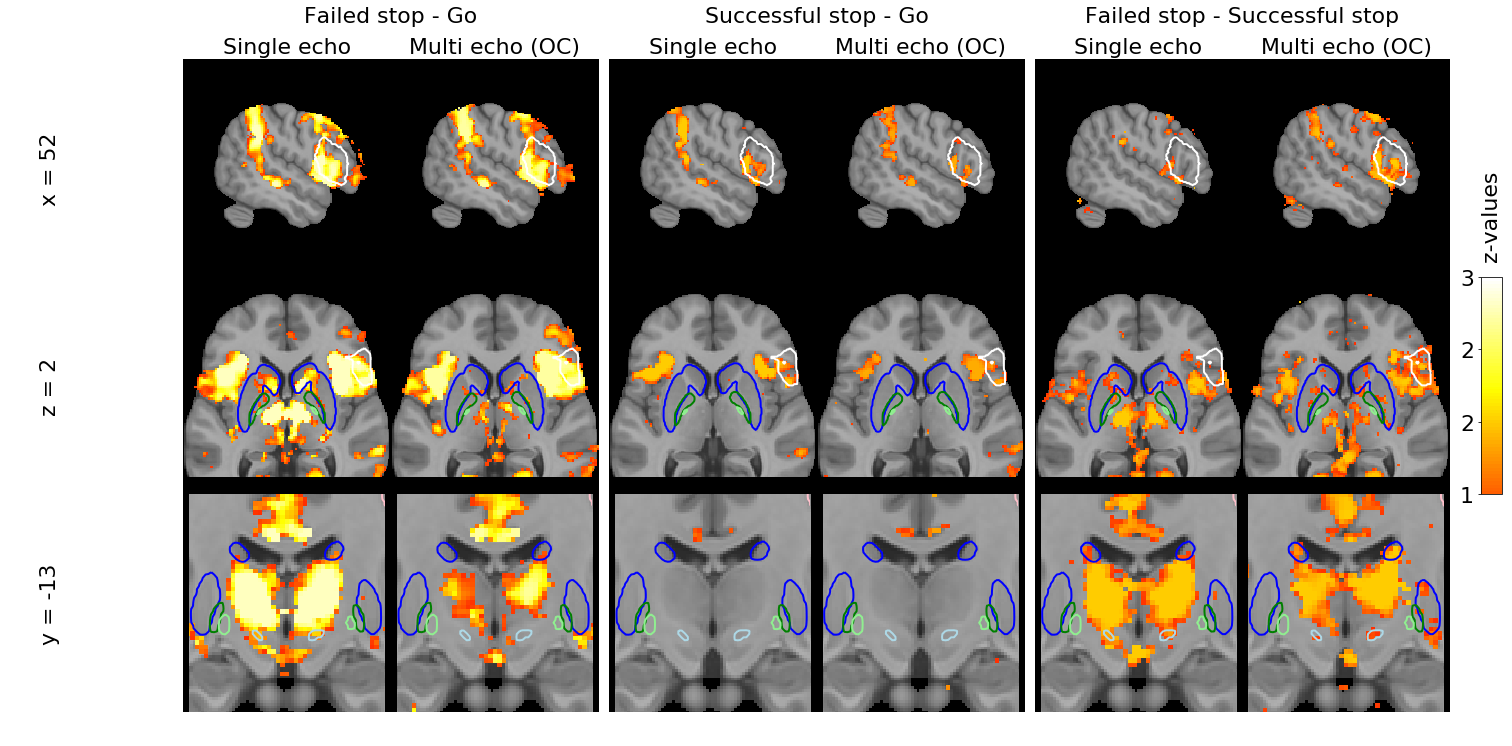

In [29]:
zmaps_combined = order_maps_thresholds([slm_se_lisa1.zmaps, slm_me_lisa1.zmaps])

zmaps_transformed = [log10_transformed(zmap) for zmap in zmaps_combined]

_ = plot_3x6(zmaps_transformed, 0, contrast_names=('Failed stop - Go', 
                                                   'Successful stop - Go',
                                                   'Failed stop - Successful stop'),
             colorbars=((1.5, 3),), vmax=3)

## 2. Two-sided FDR

In [30]:
contrasts = {'failed_stop-go_trial': 'failed_stop - go_trial',
             'successful_stop-go_trial': 'successful_stop - go_trial',
             'failed_stop-successful_stop': 'failed_stop - successful_stop'}

slm_se_lisa2 = SLM(first_level_models=first_level_models_se, level=0.025,
                   contrasts=contrasts, session='se', model_dir='model', height_control='LISA', 
                   bids_root='/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep',
                   save_dir='./second_level_models_lisa_final_alpha-p025/single_echo').fit()
slm_me_lisa2 = SLM(first_level_models=first_level_models_me, level=0.025,
                   contrasts=contrasts, session='me', model_dir='model', height_control='LISA', 
                   bids_root='/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep',
                   save_dir='./second_level_models_lisa_final_alpha-p025/multi_echo').fit()

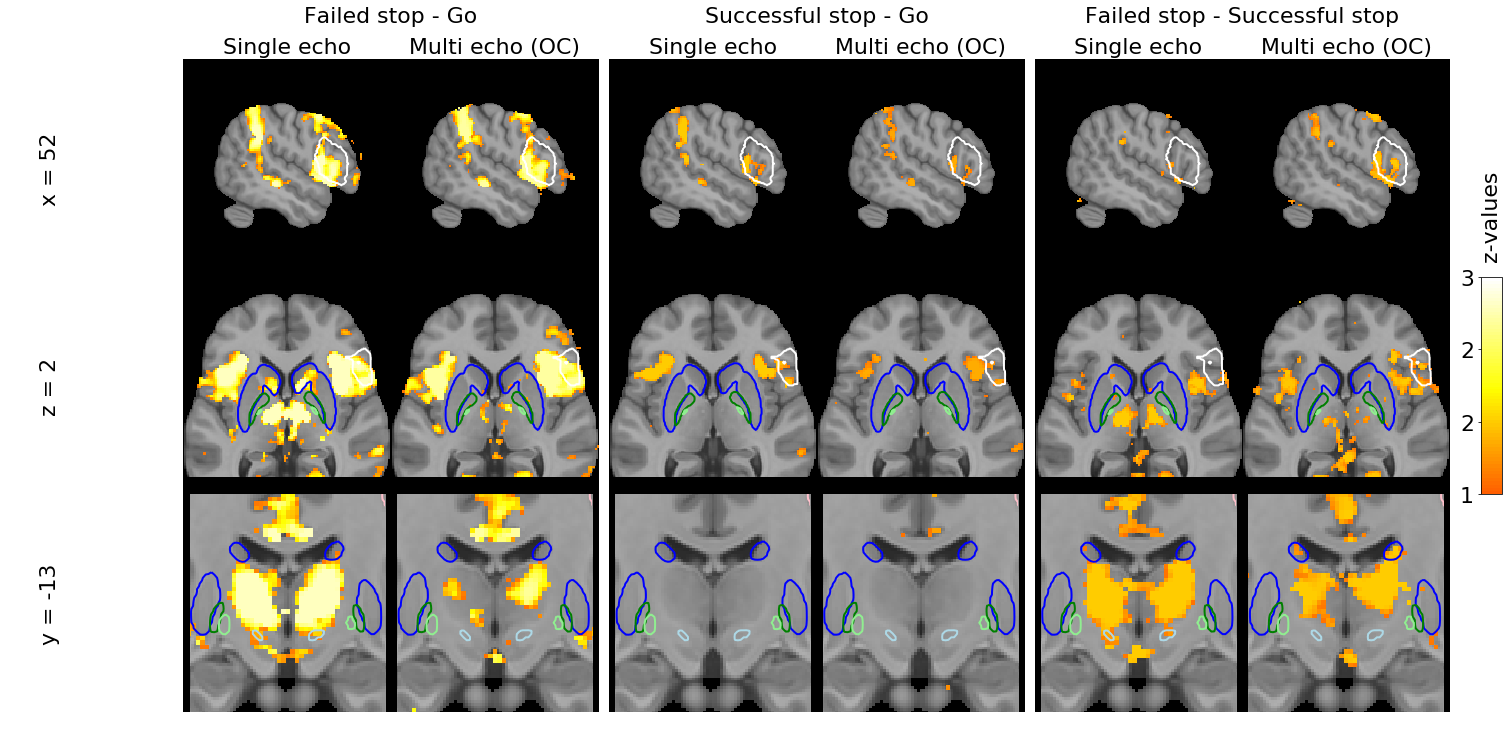

In [31]:
zmaps_combined = order_maps_thresholds([slm_se_lisa2.zmaps, slm_me_lisa2.zmaps])

zmaps_transformed = [log10_transformed(zmap) for zmap in zmaps_combined]

_ = plot_3x6(zmaps_transformed, 0, contrast_names=('Failed stop - Go', 
                                                   'Successful stop - Go',
                                                   'Failed stop - Successful stop'),
             colorbars=((1.5, 3),), vmax=3)

## 3. Inverse contrast to get "negative" contrasts

In [32]:
contrasts = {'go_trial-failed_stop': 'go_trial - failed_stop',
             'go_trial-successful_stop': 'go_trial - successful_stop',
             'successful_stop-failed_stop': 'successful_stop - failed_stop'}

slm_se_lisa3 = SLM(first_level_models=first_level_models_se, level=0.025,
                   contrasts=contrasts, session='se', model_dir='model', height_control='LISA', 
                   bids_root='/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep',
                   save_dir='./second_level_models_lisa_final_alpha-p025_inv/single_echo').fit()
slm_me_lisa3 = SLM(first_level_models=first_level_models_me, level=0.025,
                   contrasts=contrasts, session='me', model_dir='model', height_control='LISA', 
                   bids_root='/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep',
                   save_dir='./second_level_models_lisa_final_alpha-p025_inv/multi_echo').fit()

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


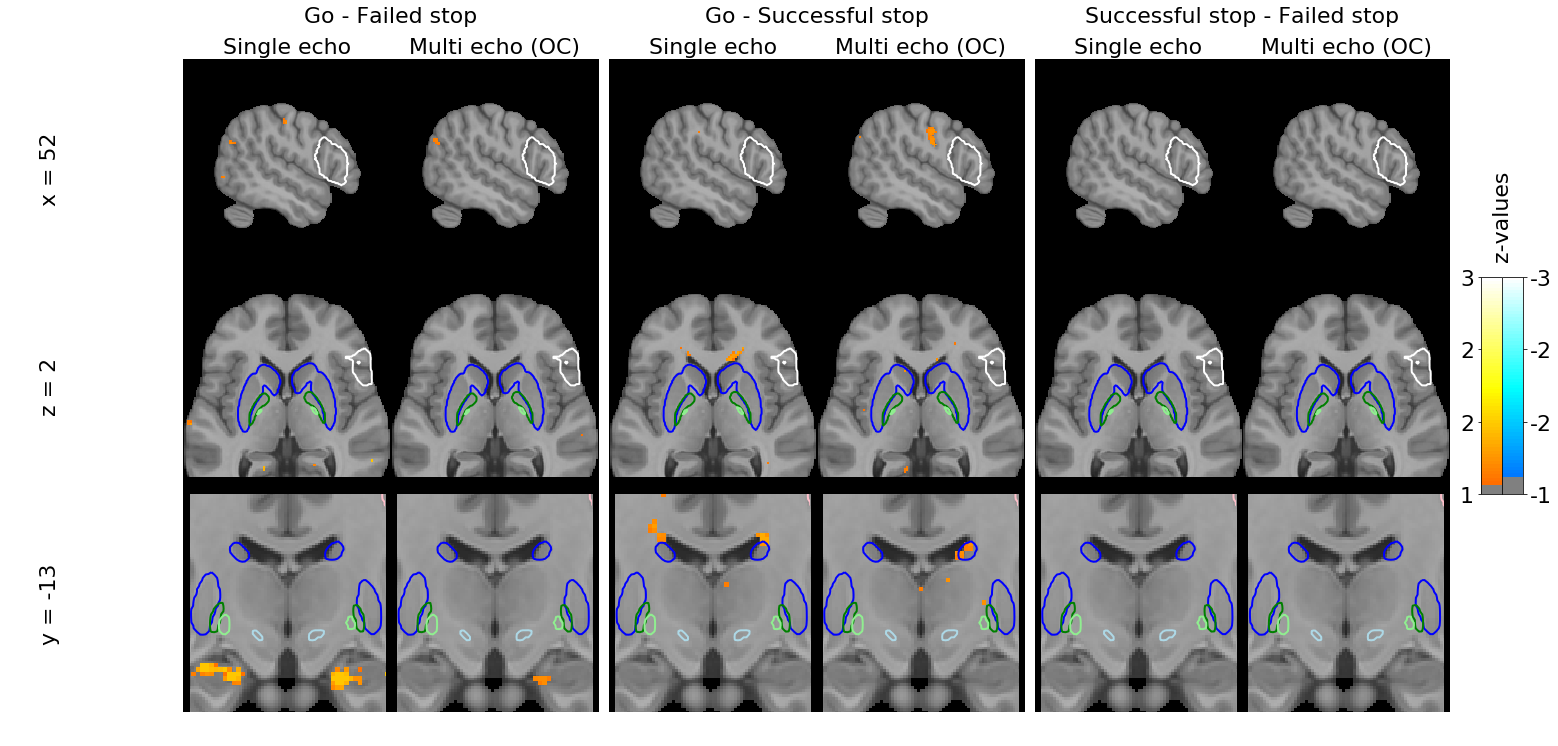

In [33]:
zmaps_combined = order_maps_thresholds([slm_se_lisa3.zmaps, slm_me_lisa3.zmaps])

zmaps_transformed = [log10_transformed(zmap) for zmap in zmaps_combined]

_ = plot_3x6(zmaps_transformed, 1.603, contrast_names=('Go - Failed stop', 
                                                       'Go - Successful stop',
                                                       'Successful stop - Failed stop'),
             colorbars=((1.5, 3), (1.5, 3)), vmax=3)

## 4. Combine zmaps to get LISA-controlled, 2-sided FDR-corrected p-maps

In [34]:
def combine_zmaps(positive_map, negative_map):
    dat_pos = positive_map.get_data()
    dat_neg = negative_map.get_data()
    
    dat_pos[dat_neg>0] = -dat_neg[dat_neg>0]
    
    return nib.Nifti1Image(dat_pos, positive_map.affine)


zmaps_pos = order_maps_thresholds([slm_se_lisa2.zmaps, slm_me_lisa2.zmaps])
zmaps_neg = order_maps_thresholds([slm_se_lisa3.zmaps, slm_me_lisa3.zmaps])

zmaps_pos = [log10_transformed(zmap) for zmap in zmaps_pos]
zmaps_neg = [log10_transformed(zmap) for zmap in zmaps_neg]

zmaps_combined = [combine_zmaps(x, y) for x, y in zip(zmaps_pos, zmaps_neg)]

# zm1 = slm_se_lisa2.zmaps['successful_stop-go_trial']
# zm2 = slm_se_lisa3.zmaps['go_trial-successful_stop']
# zm_comb = combine_zmaps(zm1, zm2)

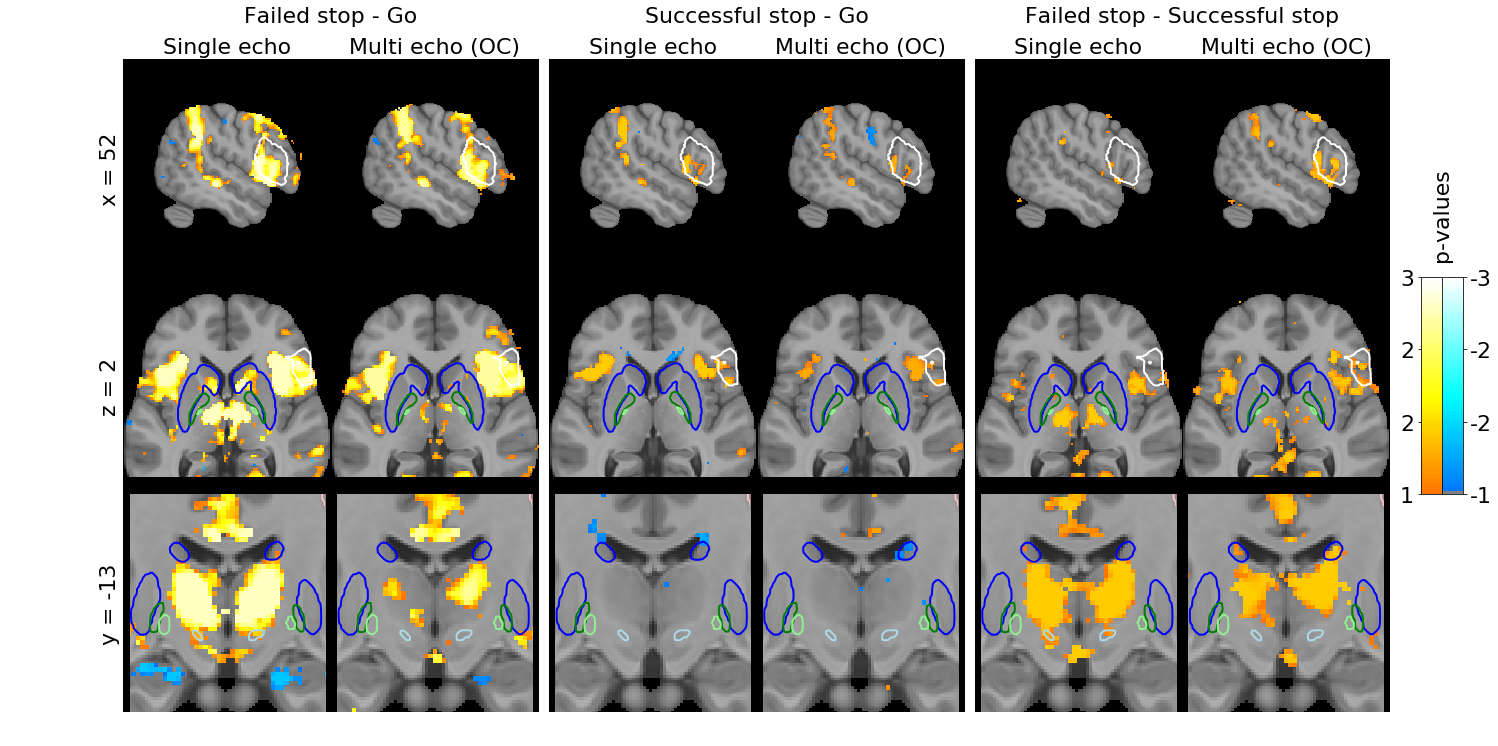

In [35]:
import matplotlib
fontsize = 22
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

f, axes = plot_3x6(zmaps_combined, 1.603, contrast_names=('Failed stop - Go', 
                                                          'Successful stop - Go',
                                                          'Failed stop - Successful stop'),
                 titles=('Single echo', 'Multi echo (OC)', 'Single echo', 'Multi echo (OC)', 'Single echo', 'Multi echo (OC)'),
                 colorbars=((1.603, 3), (1.603, 3)), 
                 vmax=3, colorbar_title='p-values')

axes[0,0].set_ylabel('', labelpad=10)
axes[1,0].set_ylabel('', labelpad=10)
axes[2,0].set_ylabel('', labelpad=10)
f.savefig('figures/glm_lisa.pdf', bbox_inches='tight')

In [36]:
# _ = plot_3x6(zmaps_combined, 1.603, contrast_names=('Failed stop > Go', 
#                                                 'Successful stop > Go',
#                                                 'Failed stop > Successful stop'),
#              colorbars=((1.5, 3), (-1.5, -3)), vmax=3)